In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style 
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter
%matplotlib inline
import seaborn as sns
from datetime import datetime
import os


In [2]:
#Avoid display of scientific notation and show precision of 4 decimals:
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

# function to add value labels
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)

# Set value labels formatter to millions
formatter = FuncFormatter(millions)
    
# Set the default color palette for seaborn
sns.set_style('whitegrid')
sns.set_palette('deep')

In [3]:
# Read csv files into a dataframe
uber = pd.read_csv('Data/uber_nyc_data.csv')

### **Initial Pre-Processing & Data Cleaning**

In [4]:
uber.head()

,id,origin_taz,destination_taz,pickup_datetime,trip_distance,trip_duration
0,252581,7C,6A,2014-09-01 09:00:00,4.25,0:15:11
1,252582,7B,15,2014-09-01 18:00:00,10.17,0:34:05
2,252583,11,2A,2014-09-01 17:00:00,4.02,0:17:06
3,252584,3B,4A,2014-09-01 13:00:00,1.46,0:06:32
4,252585,2A,10,2014-09-01 14:00:00,8.31,0:26:17


In [5]:
uber.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30925738 entries, 0 to 30925737
Data columns (total 6 columns):
 #   Column           Dtype  
---  ------           -----  
 0   id               int64  
 1   origin_taz       object 
 2   destination_taz  object 
 3   pickup_datetime  object 
 4   trip_distance    float64
 5   trip_duration    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.4+ GB


In [6]:
uber.dtypes

id                   int64
origin_taz          object
destination_taz     object
pickup_datetime     object
trip_distance      float64
trip_duration       object
dtype: object

##### Check if there are any duplicate id values

In [7]:
uber['id'].is_unique

True

##### Check for duplicate rows over entire dataframe

In [8]:
len(uber[uber.duplicated() == True])

0

##### Check for null values

In [9]:
# Get a count of nulls per column
uber.isnull().sum()

id                       0
origin_taz               0
destination_taz    1273023
pickup_datetime          0
trip_distance           38
trip_duration           38
dtype: int64

##### We can see there are 38 trip_distance and trip_duration values that are missing, as well as 1273023 destination_taz values.
 
###### Are the 38 missing trip_distance and trip_duration values on the same rows?

In [10]:
(uber[uber.trip_distance.isnull()] == uber[uber.trip_duration.isnull()]).head(10)

,id,origin_taz,destination_taz,pickup_datetime,trip_distance,trip_duration
15155317,True,True,True,True,False,False
15245057,True,True,True,True,False,False
16519652,True,True,True,True,False,False
17148253,True,True,True,True,False,False
17297563,True,True,True,True,False,False
17478943,True,True,True,True,False,False
17980063,True,True,True,True,False,False
18385948,True,True,True,True,False,False
18420794,True,True,True,True,False,False
18432788,True,True,True,True,False,False


In [11]:
len((uber[uber.trip_distance.isnull()] == uber[uber.trip_duration.isnull()]))

38

###### It looks like the missing trip_distance and trip_duration values are in fact on the same row.

###### On the note of origin_taz and destination_taz, do these have the same values?

In [12]:
distinct_origin = uber.origin_taz.unique()
len(distinct_origin)

28

In [13]:
distinct_destination = uber.destination_taz.unique()

In [14]:
set(distinct_destination) - set(distinct_origin)

{'18', nan}

###### It looks like destination_taz has two distinct value types more than origin_taz. One is the value 18 and the other is a nan value.

In [15]:
uber['pickup_datetime'] = pd.to_datetime(uber['pickup_datetime'])

##### Adding additional columns to help aggregate by various time periods

In [16]:
uber['date'] = uber['pickup_datetime'].dt.date
uber['day'] = uber['pickup_datetime'].dt.day
uber['hour'] = uber['pickup_datetime'].dt.hour
uber['month'] = uber['pickup_datetime'].dt.month_name()
uber['weekday'] = uber['pickup_datetime'].dt.day_name()

In [17]:
uber.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30925738 entries, 0 to 30925737
Data columns (total 11 columns):
 #   Column           Dtype         
---  ------           -----         
 0   id               int64         
 1   origin_taz       object        
 2   destination_taz  object        
 3   pickup_datetime  datetime64[ns]
 4   trip_distance    float64       
 5   trip_duration    object        
 6   date             object        
 7   day              int32         
 8   hour             int32         
 9   month            object        
 10  weekday          object        
dtypes: datetime64[ns](1), float64(1), int32(2), int64(1), object(6)
memory usage: 2.3+ GB


##### Convert pickup_datetime and date columns into datetime format 

In [18]:
uber['date'] = pd.to_datetime(uber['date'])

In [19]:
uber.head()

,id,origin_taz,destination_taz,pickup_datetime,trip_distance,trip_duration,date,day,hour,month,weekday
0,252581,7C,6A,2014-09-01 09:00:00,4.25,0:15:11,2014-09-01,1,9,September,Monday
1,252582,7B,15,2014-09-01 18:00:00,10.17,0:34:05,2014-09-01,1,18,September,Monday
2,252583,11,2A,2014-09-01 17:00:00,4.02,0:17:06,2014-09-01,1,17,September,Monday
3,252584,3B,4A,2014-09-01 13:00:00,1.46,0:06:32,2014-09-01,1,13,September,Monday
4,252585,2A,10,2014-09-01 14:00:00,8.31,0:26:17,2014-09-01,1,14,September,Monday


In [20]:
uber.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30925738 entries, 0 to 30925737
Data columns (total 11 columns):
 #   Column           Dtype         
---  ------           -----         
 0   id               int64         
 1   origin_taz       object        
 2   destination_taz  object        
 3   pickup_datetime  datetime64[ns]
 4   trip_distance    float64       
 5   trip_duration    object        
 6   date             datetime64[ns]
 7   day              int32         
 8   hour             int32         
 9   month            object        
 10  weekday          object        
dtypes: datetime64[ns](2), float64(1), int32(2), int64(1), object(5)
memory usage: 2.3+ GB


### Analysis

##### What is the average trip distance?

In [21]:
uber['trip_distance'].median()

3.09

In [22]:
uber['month']

0           September
1           September
2           September
3           September
4           September
              ...    
30925733    September
30925734    September
30925735    September
30925736    September
30925737    September
Name: month, Length: 30925738, dtype: object

##### Which months have the most Uber traffic and the least Uber traffic?

In [23]:
#pd.set_option('display.float_format', lambda x: f'{x:,.3f}')
monthly_counts = uber['month'].value_counts().rename_axis('month').reset_index(name='counts')
monthly_counts

,month,counts
0,August,3368433
1,July,3274909
2,June,3258756
3,May,3102400
4,April,2799204
5,March,2745708
6,February,2612856
7,January,2335184
8,December,2137157
9,November,1984232


###### We can see that the summer months are the busiest, with August being the peak month for uber traffic. July, June and May follow closely behind in that order.  
###### On the other hand, September has the least amount of Uber traffic.

#### Visualizations

In [24]:
colors = ['tab:blue', 'tab:green', 'tab:red', 'tab:orange', 'tab:purple', 'tab:cyan', 'tab:gray', 'tab:brown', 'tab:pink', 'tab:olive', 'lime', 'royalblue']

##### Visualize Uber traffic by month

Text(0, 0.5, 'Total Trips')

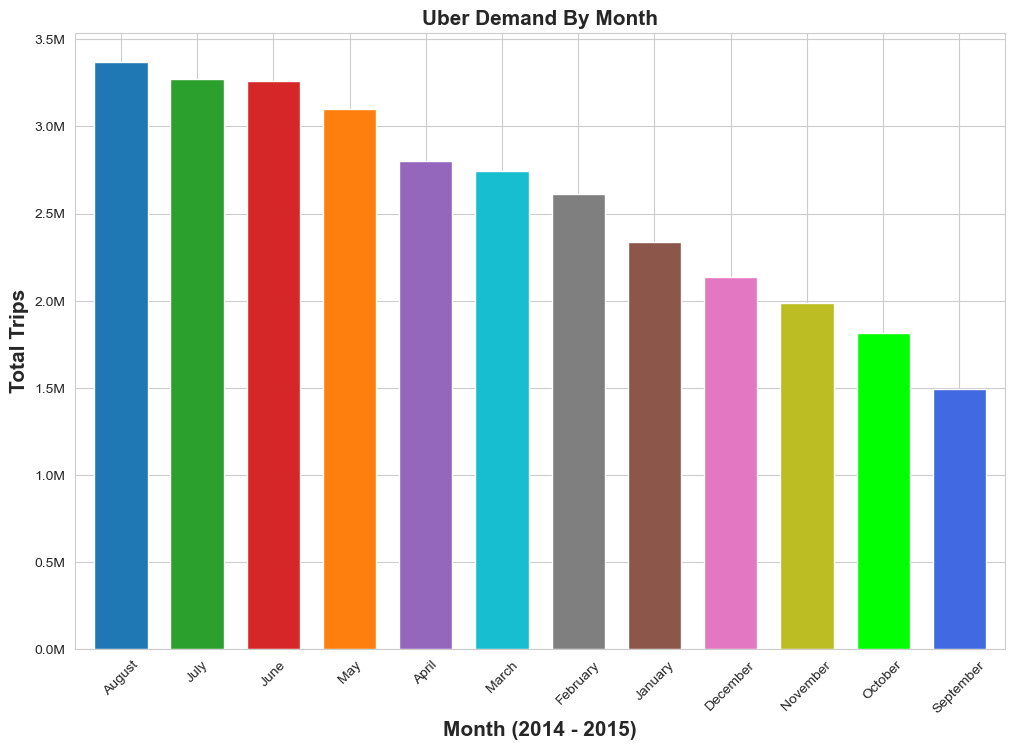

In [25]:
# Set descriptions of data
plt.title("Uber Demand By Month", weight='bold', size=15)
plt.xticks(rotation=45)
monthly_bar = uber['month'].value_counts().plot(kind='bar', figsize=(12,8), color=colors, width=0.7)
monthly_bar.tick_params(axis='x', labelrotation = 45)
monthly_bar.yaxis.set_major_formatter(formatter)
monthly_bar.set_xlabel("Month (2014 - 2015)", weight='bold', size=15)
monthly_bar.set_ylabel("Total Trips", weight='bold', size=15)


Again, we can see that August is the busiest month and September is the least busiest.

##### Visualize Total Trips By Weekday

Text(0, 0.5, 'Total Trips')

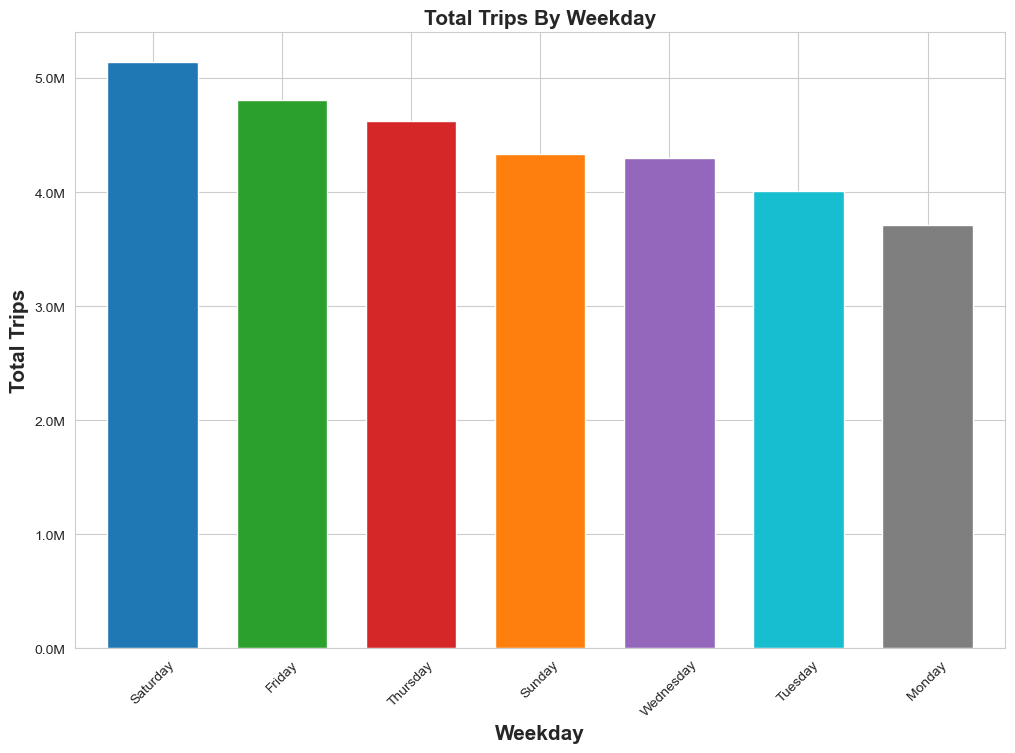

In [26]:
plt.title("Total Trips By Weekday", weight='bold', size=15)
plt.xticks(rotation=45)
daily_bar = uber['weekday'].value_counts().plot(kind='bar', figsize=(12,8), color=colors, width=0.7)
daily_bar.tick_params(axis='x', labelrotation = 45)
daily_bar.yaxis.set_major_formatter(formatter)
daily_bar.set_xlabel("Weekday", weight='bold', size=15)
daily_bar.set_ylabel("Total Trips", weight='bold', size=15)

We can see that Saturday has the most Uber traffic of all the weekdays.

##### Visualize the number of weekday rides per month

Create pivot table of daily rides per month

In [27]:
pivot_month = pd.crosstab(index=uber['month'], columns=uber['weekday'])
pivot_month 

weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
month,,,,,,,
April,415996,310076,435899,371880,491552,328242,445559
August,465946,458912,606416,554937,450979,410289,420954
December,307518,284035,330012,259201,271812,334061,350518
February,431983,326466,433551,363613,386993,335509,334741
January,404687,234340,469059,295055,399120,236796,296127
July,545808,354020,446833,419383,570474,403037,535354
June,466422,472246,509872,429154,455072,511971,414019
March,408884,351692,422054,432296,365453,424703,340626
May,532955,313755,586263,495287,422437,356927,394776


Create a bar chart from the pivot_month table

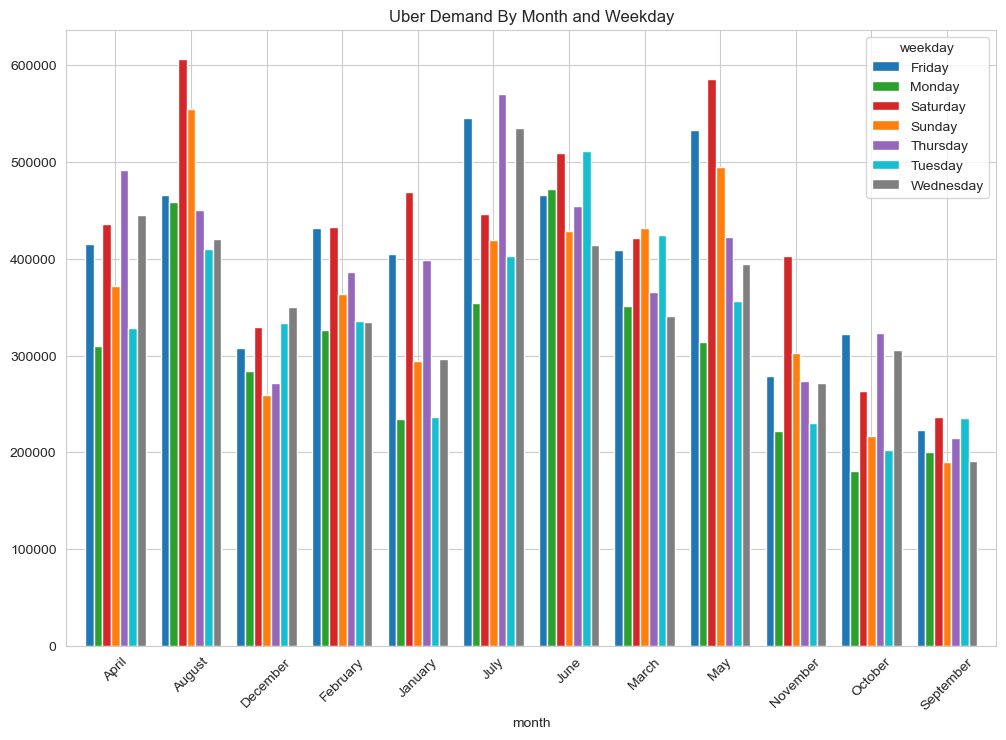

In [28]:
month_weekday = pivot_month.plot(kind='bar', figsize=(12,8), color=colors, width=0.8)
month_weekday.set_title('Uber Demand By Month and Weekday')
month_weekday.tick_params(axis='x', labelrotation = 45)

Though the summer months have more demain in general, we can see that August has the peak weekend Uber demand. Its interesting to note that May is close behidn August with a high weekend demand. Could it be due to Memorial Day weekend and Mothers Day? We will explore holiday traffic later.

##### Hourly Uber Demand By Day Of The Week

In [29]:
summary = uber.groupby(['weekday', 'hour'], as_index=False).size()
summary.head()

,weekday,hour,size
0,Friday,0,249006
1,Friday,1,145993
2,Friday,2,82687
3,Friday,3,51465
4,Friday,4,45535


Text(0.5, 1.0, 'Total Hourly Uber Traffic By Day Of Week')

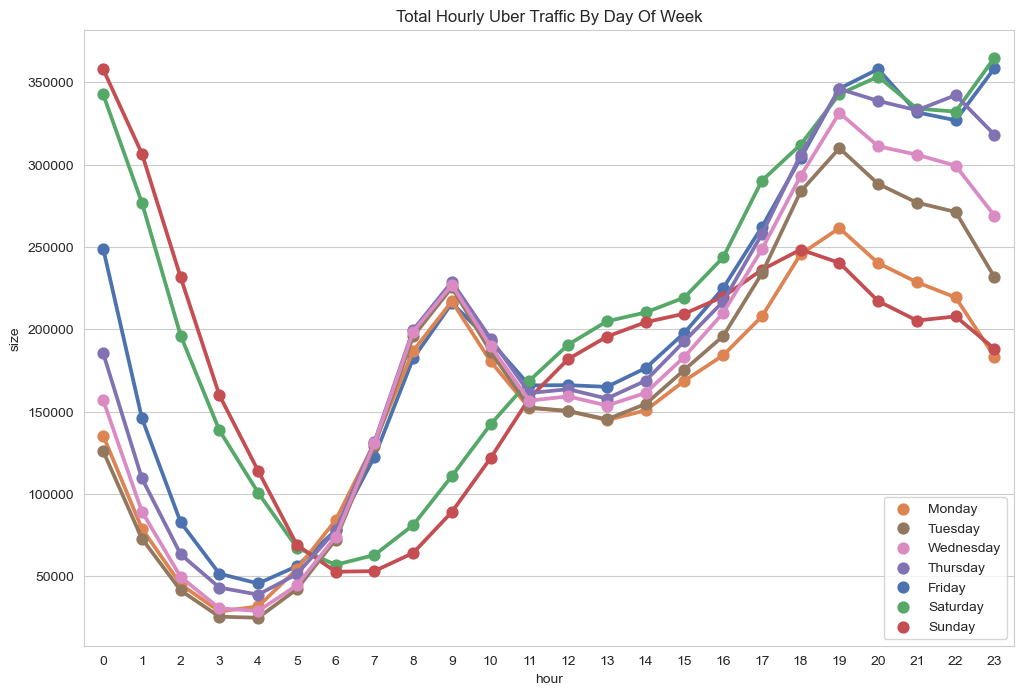

In [30]:
plt.figure(figsize=(12,8))
palette = {'Friday':'tab:blue','Monday':'tab:green', 'Saturday':'tab:red', 'Sunday':'tab:cyan', 'Thursday':'tab:purple', 'Tuesday':'tab:orange', 'Wednesday':'tab:gray'}
uber_hourly = sns.pointplot(data=summary, x="hour", y="size", hue="weekday")
handles, labels = uber_hourly.get_legend_handles_labels()                       # Get legend handles and lables  
order = [1,5,6,4,0,2,3]                                                         # Set an order for legend items                                  
uber_hourly.legend([handles[i] for i in order], [labels[i] for i in order])
uber_hourly.set_title('Total Hourly Uber Traffic By Day Of Week')     # Reorder legend

One thing that stands out is how similar Saturday and Sunday are from early morning to late afternoon. But around 3:00pm its starts to diverge, eventuly going in opposite directions. Uber demand is at its peak on Saturday night but demand on Sunday night is the lowest of all weekdays.

##### What is the average trip distance per month?

In [31]:

pivot_monthly_distance = uber.groupby('month')['trip_distance'].median().reset_index()
pivot_monthly_distance

,month,trip_distance
0,April,3.16
1,August,3.27
2,December,3.02
3,February,2.81
4,January,2.85
5,July,3.18
6,June,3.09
7,March,2.98
8,May,3.23
9,November,3.06


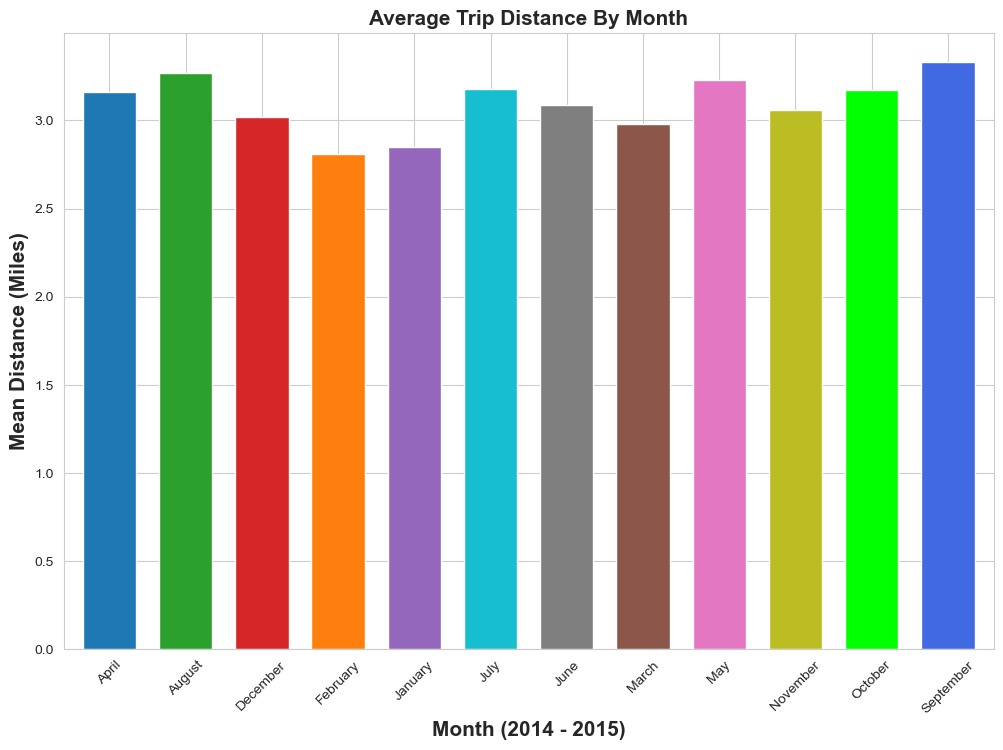

In [32]:
monthly_distance = pivot_monthly_distance.plot(kind='bar', x='month', y='trip_distance', figsize=(12,8), color=colors, width=0.7)
monthly_distance.set_title("Average Trip Distance By Month", weight='bold', size=15)
monthly_distance.tick_params(axis='x', labelrotation = 45)
monthly_distance.set_xlabel("Month (2014 - 2015)", weight='bold', size=15)
monthly_distance.set_ylabel("Mean Distance (Miles)", weight='bold', size=15)
monthly_distance.get_legend().remove()

September may have the least amount of trips per month but the trips that is does have appear to be the longest on average. August is close behind however.

##### What is the average trip distance per weekday?

In [33]:
pivot_weekday_distance = uber.groupby('weekday')['trip_distance'].median().reset_index()
pivot_weekday_distance

,weekday,trip_distance
0,Friday,3.02
1,Monday,3.15
2,Saturday,3.07
3,Sunday,3.45
4,Thursday,3.06
5,Tuesday,2.94
6,Wednesday,2.99


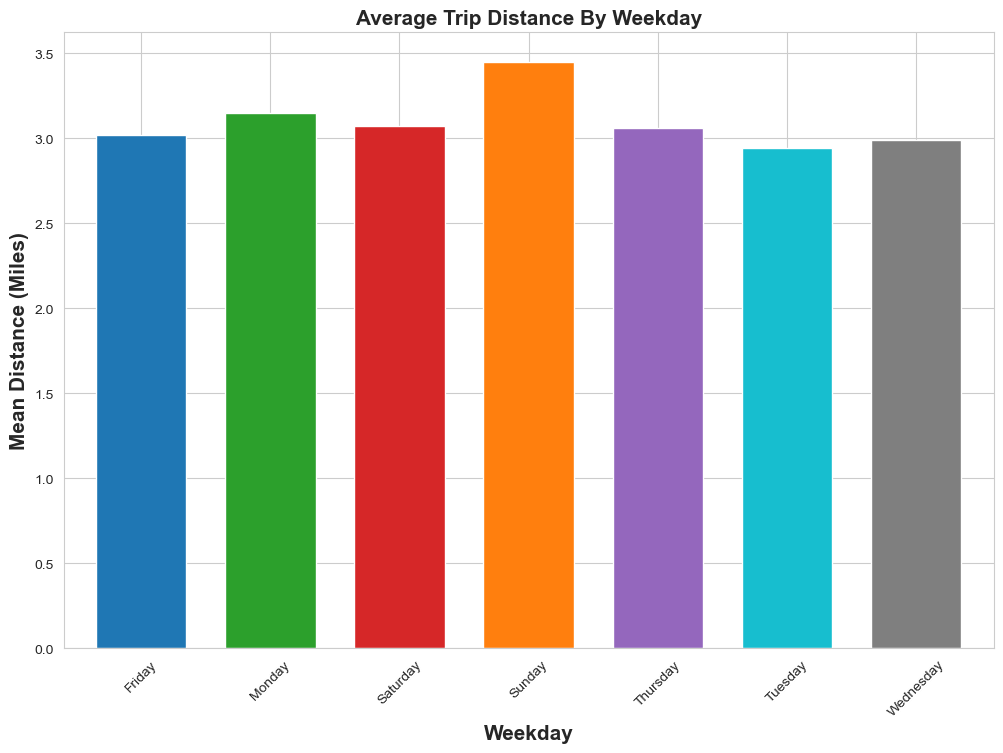

In [34]:
weekday_distance = pivot_weekday_distance.plot(kind='bar', x='weekday', y='trip_distance', figsize=(12,8), color=colors, width=0.7)
weekday_distance.set_title("Average Trip Distance By Weekday", weight='bold', size=15)
weekday_distance.tick_params(axis='x', labelrotation = 45)
weekday_distance.set_xlabel("Weekday", weight='bold', size=15)
weekday_distance.set_ylabel("Mean Distance (Miles)", weight='bold', size=15)
weekday_distance.get_legend().remove()

 ##### Create a heatmap table to represent ride count grouped by day of month and hour of day.
 For each day, the ride count values are shaded from white to blue to dark blue. The darker the blue for each hour of day, the higher the ride count for that day.
 ##### Note: The following code does not display with the background color gradient when this notebook is viewed in github.

In [41]:
pivot_day = uber.groupby(['day', 'hour']).size().unstack()
pivot_day.style.background_gradient(cmap='Blues')

hour,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
day,,,,,,,,,,,,,,,,,,,,,,,,
1,58523,49241,36938,30164,23127,17634,16952,22406,31111,36683,34946,35892,38483,38853,40359,43905,48900,56493,65032,68622,64166,61710,60643,60911
2,46595,33068,21623,13155,10805,11587,15759,24060,35627,42519,38474,34739,36077,36674,38826,43270,48087,55815,63525,69318,65640,61303,60599,55054
3,41543,28876,20299,12789,10658,11639,15840,24908,34643,41465,37114,33930,34897,35630,38530,42334,46844,54706,62260,67638,63922,60449,59253,54456
4,42285,27657,17361,11916,10377,10899,15034,23643,34249,39487,36840,34149,35744,35577,36915,39515,43941,51249,59578,65499,62316,60356,59733,57124
5,47039,31474,19701,13101,10750,11167,15159,25106,37188,43450,38997,35848,36913,36320,38572,42012,43937,53651,63083,70062,66930,65407,64312,60512
6,48273,31164,19055,12194,9906,11662,16590,26687,39408,46033,41408,37300,37538,37390,39772,43765,48968,56336,66813,72586,71449,69270,67387,66091
7,57829,41470,27459,17830,13574,12236,14683,22049,32379,38797,36041,34517,36569,37519,39658,43377,48201,57454,66424,74050,71582,65793,66287,64171
8,51848,35925,22085,15372,14191,13260,15786,23988,35125,41555,36709,33730,37022,36950,39056,42553,47966,56434,63391,68969,65048,61739,61135,58791
9,47061,32161,20660,13679,11059,11384,15820,26586,39637,47318,43228,38100,39050,38020,40187,44543,48461,55829,63675,69668,66449,65995,66516,59089


##### Popluar Pickup And Destination Combinations

In [36]:
pickup_vs_destination = uber.pivot_table('id', aggfunc='count', index='origin_taz', columns='destination_taz')

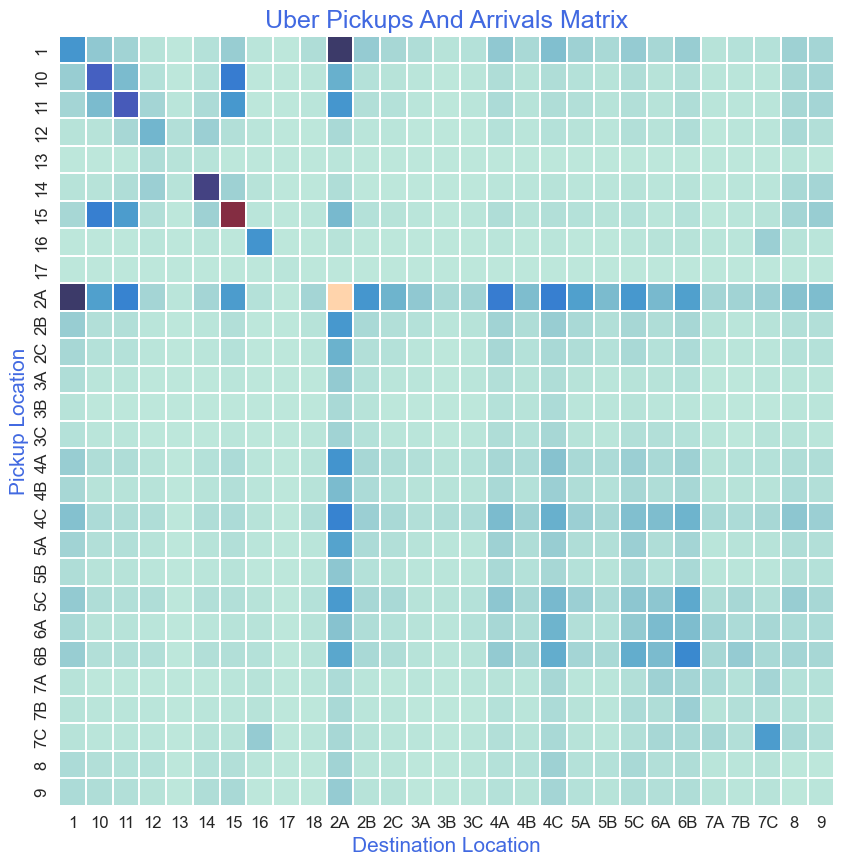

In [37]:
fig = plt.figure(figsize=(10,10))

cmap = sns.color_palette("viridis", as_cmap=True)

sns.heatmap(pickup_vs_destination, cmap="icefire", linewidths=0.1, cbar=False)

plt.title('Uber Pickups And Arrivals Matrix', fontsize=18, color='royalblue')
plt.xlabel('Destination Location', fontsize=15, color='royalblue')
plt.ylabel('Pickup Location', fontsize=15, color='royalblue')
plt.tick_params(labelsize=12)
plt.show()

Location data has been anonymized, but we can still see which combination of pickup location and dropoff location pairs are most popular.
2A appears to be the most popular pickup and dropoff location overall.